## Load data and calculate coefficients

In [1]:
import os
import sys
sys.path.append("../") # go to parent dir
import glob
import time
import pathlib
import logging
import numpy as np
from scipy.sparse import linalg as spla
from dedalus.tools.config import config
from simple_sphere import SimpleSphere, TensorField, TensorSystem
import equations
import matplotlib.pyplot as plt
%matplotlib inline
#import cartopy.crs as ccrs
#from dedalus.extras import plot_tools
import logging
from mpl_toolkits import mplot3d
logger = logging.getLogger(__name__) 
from matplotlib.animation import FFMpegWriter
from matplotlib.patches import Rectangle, Wedge
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

STRNAME = "sphere118"
#add path to data folder
input_folder = "/Volumes/ExtDrive/data"
output_folder = "/Users/Rohit/Documents/research/active_matter_spheres/scripts/garbage"
first_frame = 1
last_frame = len(glob.glob1('%s/%s/' %(input_folder, STRNAME),"*.npz"))
#last_frame = 3000
dpi = 256
Omega = 500
if STRNAME == "sphere118":
    Lmid = 8
elif STRNAME == "sphere110":
    Lmid = 4
else: 
    Lmid = 2

# Setup output folder
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

print('Total time stamps = %i' %(last_frame-first_frame))

Total time stamps = 4999


In [2]:
t_arr = np.zeros(last_frame)

for ind in range(first_frame, last_frame + 1, 1):
    if np.mod(ind,100)==0: logger.info('Frame:%i'%(ind))
    
    with np.load('%s/%s/output_%i.npz' %(input_folder, STRNAME, ind)) as file:
        if ind == first_frame:
            phi = file['phi']
            theta = file['theta']
            L_max = len(theta)-1
            S_max = 4
            simplesphere = SimpleSphere(L_max, S_max)
            omega = TensorField(simplesphere, rank=0)
            coeffs_all = np.zeros((last_frame,L_max+1, L_max+1), dtype=complex)

        om = file['om']
        time = file['t'][0]
        t_arr[ind-1] = time


    # assign loaded data
    omega.component_fields[0]['g'] = om
    # spectral transform
    omega.forward_phi()
    omega.forward_theta()
    coeffs = omega.coeffs
    
    #coeff1[ind-1] = coeffs[m_1][ell_1-m_1]
    #coeff2[ind-1] = coeffs[m_2][ell_2-m_2]
    for m in range(len(coeffs)):
        coeffs_all[ind-1, m, m:] = coeffs[m]

2019-10-24 15:17:34,877 __main__ 0/1 INFO :: Frame:100
2019-10-24 15:17:40,766 __main__ 0/1 INFO :: Frame:200
2019-10-24 15:17:46,831 __main__ 0/1 INFO :: Frame:300
2019-10-24 15:17:53,327 __main__ 0/1 INFO :: Frame:400
2019-10-24 15:17:59,462 __main__ 0/1 INFO :: Frame:500
2019-10-24 15:18:05,226 __main__ 0/1 INFO :: Frame:600
2019-10-24 15:18:10,285 __main__ 0/1 INFO :: Frame:700
2019-10-24 15:18:15,916 __main__ 0/1 INFO :: Frame:800
2019-10-24 15:18:21,114 __main__ 0/1 INFO :: Frame:900
2019-10-24 15:18:27,286 __main__ 0/1 INFO :: Frame:1000
2019-10-24 15:18:33,343 __main__ 0/1 INFO :: Frame:1100
2019-10-24 15:18:38,633 __main__ 0/1 INFO :: Frame:1200
2019-10-24 15:18:44,399 __main__ 0/1 INFO :: Frame:1300
2019-10-24 15:18:49,876 __main__ 0/1 INFO :: Frame:1400
2019-10-24 15:18:55,849 __main__ 0/1 INFO :: Frame:1500
2019-10-24 15:19:00,835 __main__ 0/1 INFO :: Frame:1600
2019-10-24 15:19:06,321 __main__ 0/1 INFO :: Frame:1700
2019-10-24 15:19:11,311 __main__ 0/1 INFO :: Frame:1800
2

In [7]:
#get gammas from Lmid and kappa setting R=1 and tau=1
def get_gammas(Lmid, kappa):
    
    a = 0.25*(Lmid**2*kappa**2 - 0.5*(2*np.pi*Lmid+1)**2)**2 + 17*17/16 - (34/16)*(2*np.pi*Lmid+1)**2
    b = (17/4 - 0.25*(2*np.pi*Lmid+1)**2)**2
    c = 1/(17/4 - 0.25*(2*np.pi*Lmid + 1)**2 - 2)
    gamma0 = a*c/(a-b)
    gamma2 = -2*np.sqrt(b)*c/(a-b)
    gamma4 = c/(a-b)
    
    return [gamma0, gamma2, gamma4]

#define function that returns the neutral ell's for a given R/Lambda and kappa
def get_l(Lmid, kappa):
    
    gamma0, gamma2, gamma4 = get_gammas(Lmid, kappa)
    delta_p = (0.5/gamma4)*(-gamma2+np.sqrt(gamma2**2-4*gamma0*gamma4))
    delta_m = (0.5/gamma4)*(-gamma2-np.sqrt(gamma2**2-4*gamma0*gamma4))
    
    l_p = 0.5*(-1+np.sqrt(17+4*delta_p))
    l_m = 0.5*(-1+np.sqrt(17+4*delta_m))
        
    return l_m, l_p

def get_k(γ0, γ2, γ4):
    k_m = np.sqrt((-γ2 - np.sqrt(γ2**2 - 4*γ0*γ4))/(2*γ4))
    k_p = np.sqrt((-γ2 + np.sqrt(γ2**2 - 4*γ0*γ4))/(2*γ4))
    
    return k_m, k_p

def get_kmax(γ0, γ2, γ4):
    k_max = np.sqrt(-γ2/(2*γ4))
    
    return k_max
    


## Plot the vorticity and coefficients

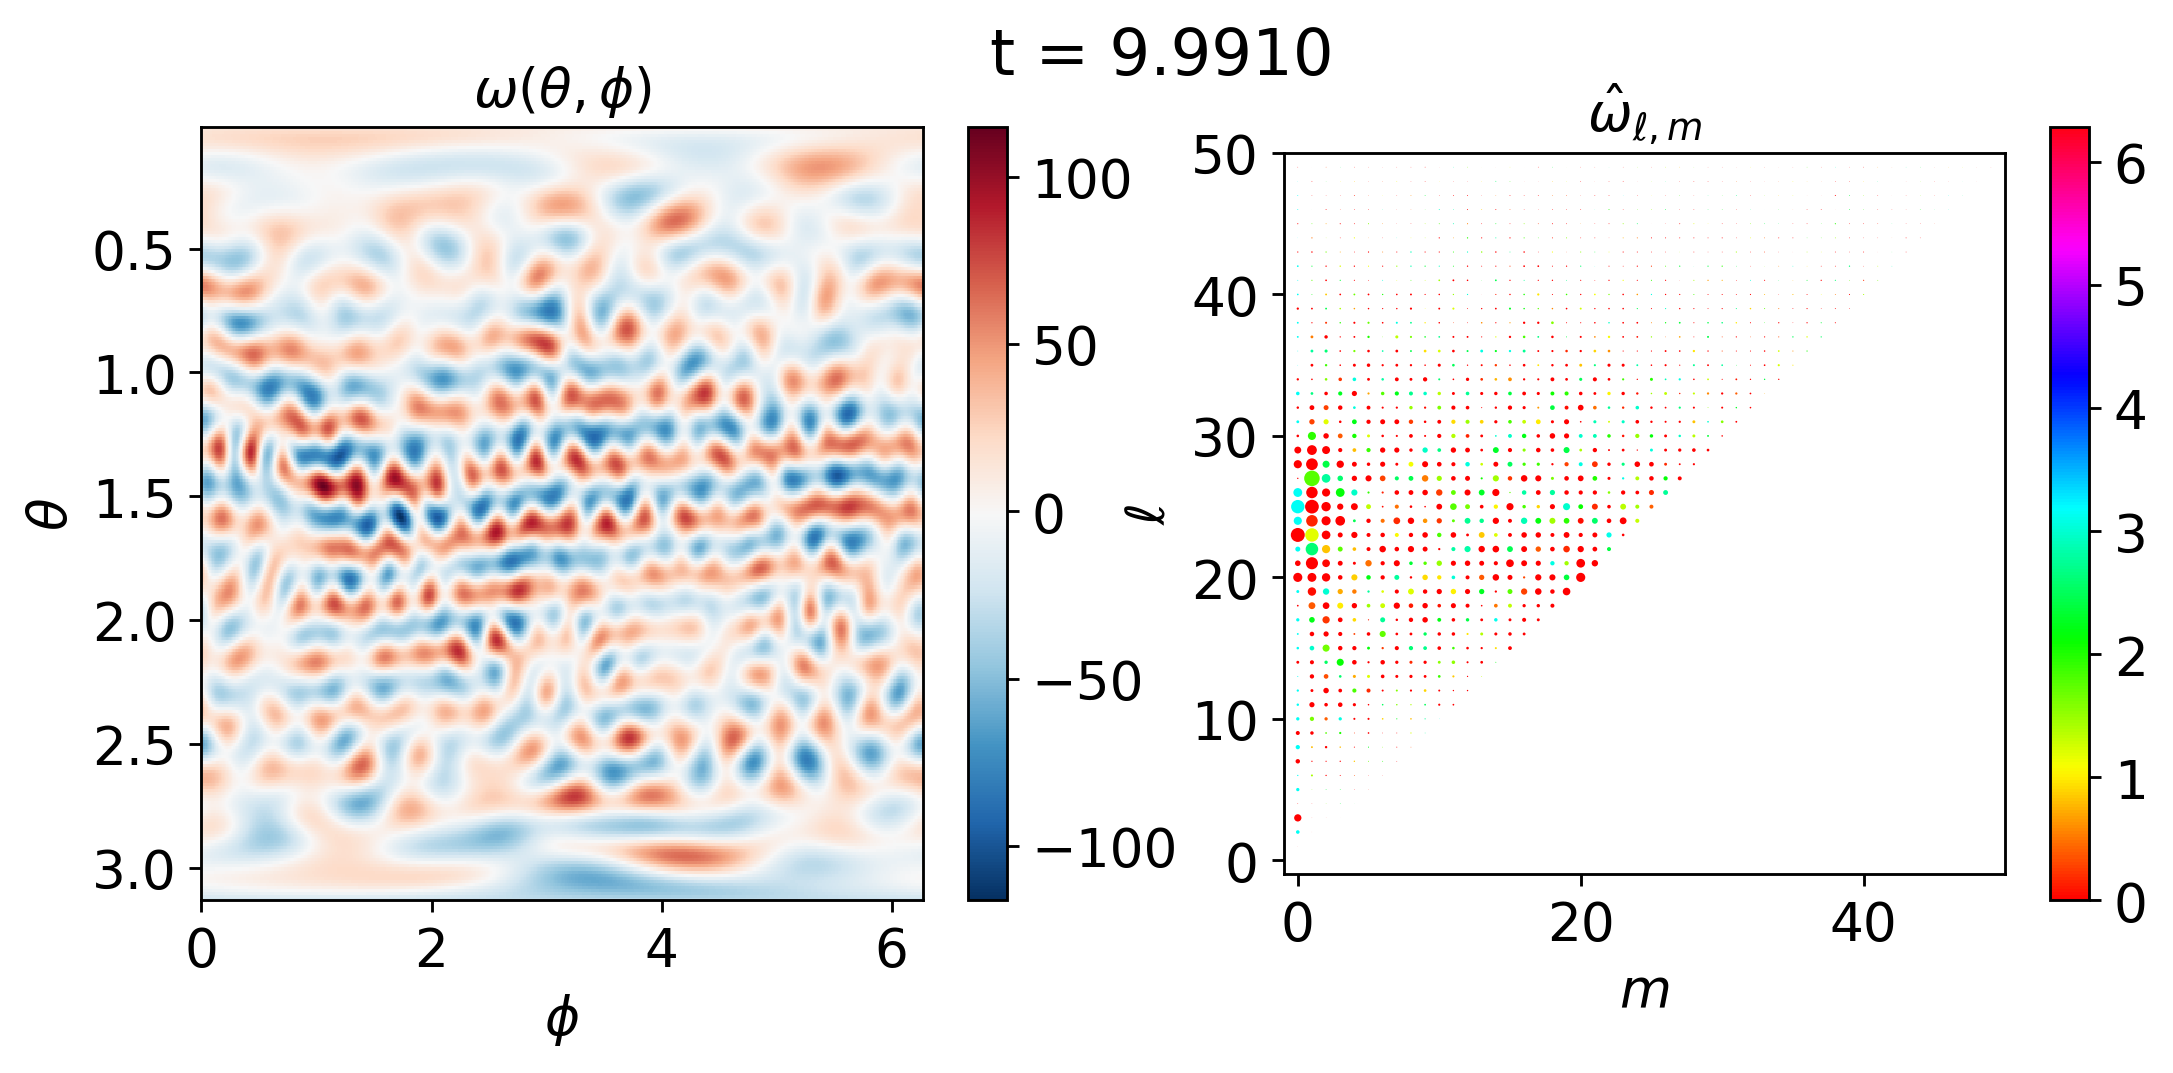

In [21]:
fig, ax = plt.subplots(1,2,figsize=(10, 4), dpi=dpi)
fig.subplots_adjust(hspace=.4)
#plotting
plt.rc('font', size=15)

ind = 1000
ell_max = 50 #for plotting

with np.load('%s/%s/output_%i.npz' %(input_folder, STRNAME, ind)) as file:
    phi = file['phi']
    theta = file['theta']
    L_max = len(theta)-1
    S_max = 4
    om = file['om']
    time = file['t'][0]


m = np.arange(0,L_max+1)
ell = np.arange(0,L_max+1)
ellell, mm = np.meshgrid(ell, m)

coeffs_arr = coeffs_all[ind, :, :]

mag = np.abs(coeffs_arr)
phase = np.angle(coeffs_arr)

title = fig.suptitle('t = %.4f' %time)

image0 = ax[0].pcolormesh(phi, theta, om.T, cmap='RdBu_r')
ax[0].set_ylabel("$\\theta$"), ax[0].set_xlabel("$\phi$")
ax[0].set_title("$\omega (\\theta, \phi)$",fontsize=15)
ax[0].invert_yaxis()
fig.colorbar(image0, ax=ax[0])

image1 = ax[1].scatter(mm.flatten(), ellell.flatten(), 2*mag.flatten(), c=phase.flatten(), cmap='hsv', edgecolor='none')
ax[1].set_xlim(-1, ell_max), ax[1].set_ylim(-1, ell_max)
ax[1].set_xlabel('$m$'), ax[1].set_ylabel('$\ell$')
ax[1].set_title('$\hat{\omega}_{\ell, m}$',fontsize=15)
ax[1].set_aspect('equal')
image1.set_clim(0, 2*np.pi)
fig.colorbar(image1, ax=ax[1])


## Find the phase speed of the coefficients

In [10]:
dt = t_arr[2] - t_arr[1]
phase_speed = np.zeros_like(coeffs_all)
phase = np.zeros_like(coeffs_all)
m = np.arange(0,L_max+1)
ell = np.arange(0,L_max+1)
ellell, mm = np.meshgrid(ell, m)

l_m, l_p = get_l(Lmid, 1)
l_m = int(np.floor(l_m))
l_p = int(np.floor(l_p))

thresh = 1e-1

for ind in range(len(t_arr)):
    if np.mod(ind+1,100)==0: logger.info('Frame:%i'%(ind+1))
    if ind != len(t_arr)-1:
        coeffs_der = (coeffs_all[ind+1, :, :] - coeffs_all[ind, :, :])/dt
        Amp = 0.5*(np.abs(coeffs_all[ind, :, :]) + np.abs(coeffs_all[ind+1, :, :]))
    else: 
        coeffs_der = (coeffs_all[ind, :, :] - coeffs_all[ind-1, :, :])/dt
        Amp = 0.5*(np.abs(coeffs_all[ind, :, :]) + np.abs(coeffs_all[ind-1, :, :]))

    phase[ind, :, :] = np.angle(coeffs_all[ind,:,:])
    phase_speed[ind, :, :] = np.imag(np.conj(coeffs_all[ind,:,:])*coeffs_der/(Amp**2))/mm
    phase_speed[ind,:, l_p:] = np.nan
    phase_speed[ind,:, :l_m] = np.nan
    
    #inds = np.where(Amp < thresh)
    #(phase_speed[ind, :, :])[inds] = np.nan
    
    


//anaconda3/envs/dedalus/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


2019-10-24 15:28:16,935 __main__ 0/1 INFO :: Frame:100
2019-10-24 15:28:17,743 __main__ 0/1 INFO :: Frame:200
2019-10-24 15:28:18,522 __main__ 0/1 INFO :: Frame:300
2019-10-24 15:28:19,349 __main__ 0/1 INFO :: Frame:400
2019-10-24 15:28:20,126 __main__ 0/1 INFO :: Frame:500
2019-10-24 15:28:20,915 __main__ 0/1 INFO :: Frame:600
2019-10-24 15:28:21,804 __main__ 0/1 INFO :: Frame:700
2019-10-24 15:28:22,667 __main__ 0/1 INFO :: Frame:800
2019-10-24 15:28:23,547 __main__ 0/1 INFO :: Frame:900
2019-10-24 15:28:24,387 __main__ 0/1 INFO :: Frame:1000
2019-10-24 15:28:25,302 __main__ 0/1 INFO :: Frame:1100
2019-10-24 15:28:26,096 __main__ 0/1 INFO :: Frame:1200
2019-10-24 15:28:26,884 __main__ 0/1 INFO :: Frame:1300
2019-10-24 15:28:27,707 __main__ 0/1 INFO :: Frame:1400
2019-10-24 15:28:28,488 __main__ 0/1 INFO :: Frame:1500
2019-10-24 15:28:29,262 __main__ 0/1 INFO :: Frame:1600
2019-10-24 15:28:30,055 __main__ 0/1 INFO :: Frame:1700
2019-10-24 15:28:30,879 __main__ 0/1 INFO :: Frame:1800
2

In [23]:
mean_phase_speed = np.real(np.nanmean(phase_speed[1000:, :, :], axis=0))
np.nanmean(mean_phase_speed*ellell*(ellell+1)/(2*Omega))

//anaconda3/envs/dedalus/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


1.081304008260333

2019-10-24 18:26:09,047 matplotlib.texmanager 0/1 INFO :: No LaTeX-compatible font found for the serif font family in rcParams. Using default.
2019-10-24 18:26:09,049 matplotlib.texmanager 0/1 INFO :: No LaTeX-compatible font found for the serif font family in rcParams. Using default.


//anaconda3/envs/dedalus/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
//anaconda3/envs/dedalus/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


2019-10-24 18:26:15,208 matplotlib.texmanager 0/1 INFO :: No LaTeX-compatible font found for the serif font family in rcParams. Using default.
2019-10-24 18:26:15,210 matplotlib.texmanager 0/1 INFO :: No LaTeX-compatible font found for the serif font family in rcParams. Using default.


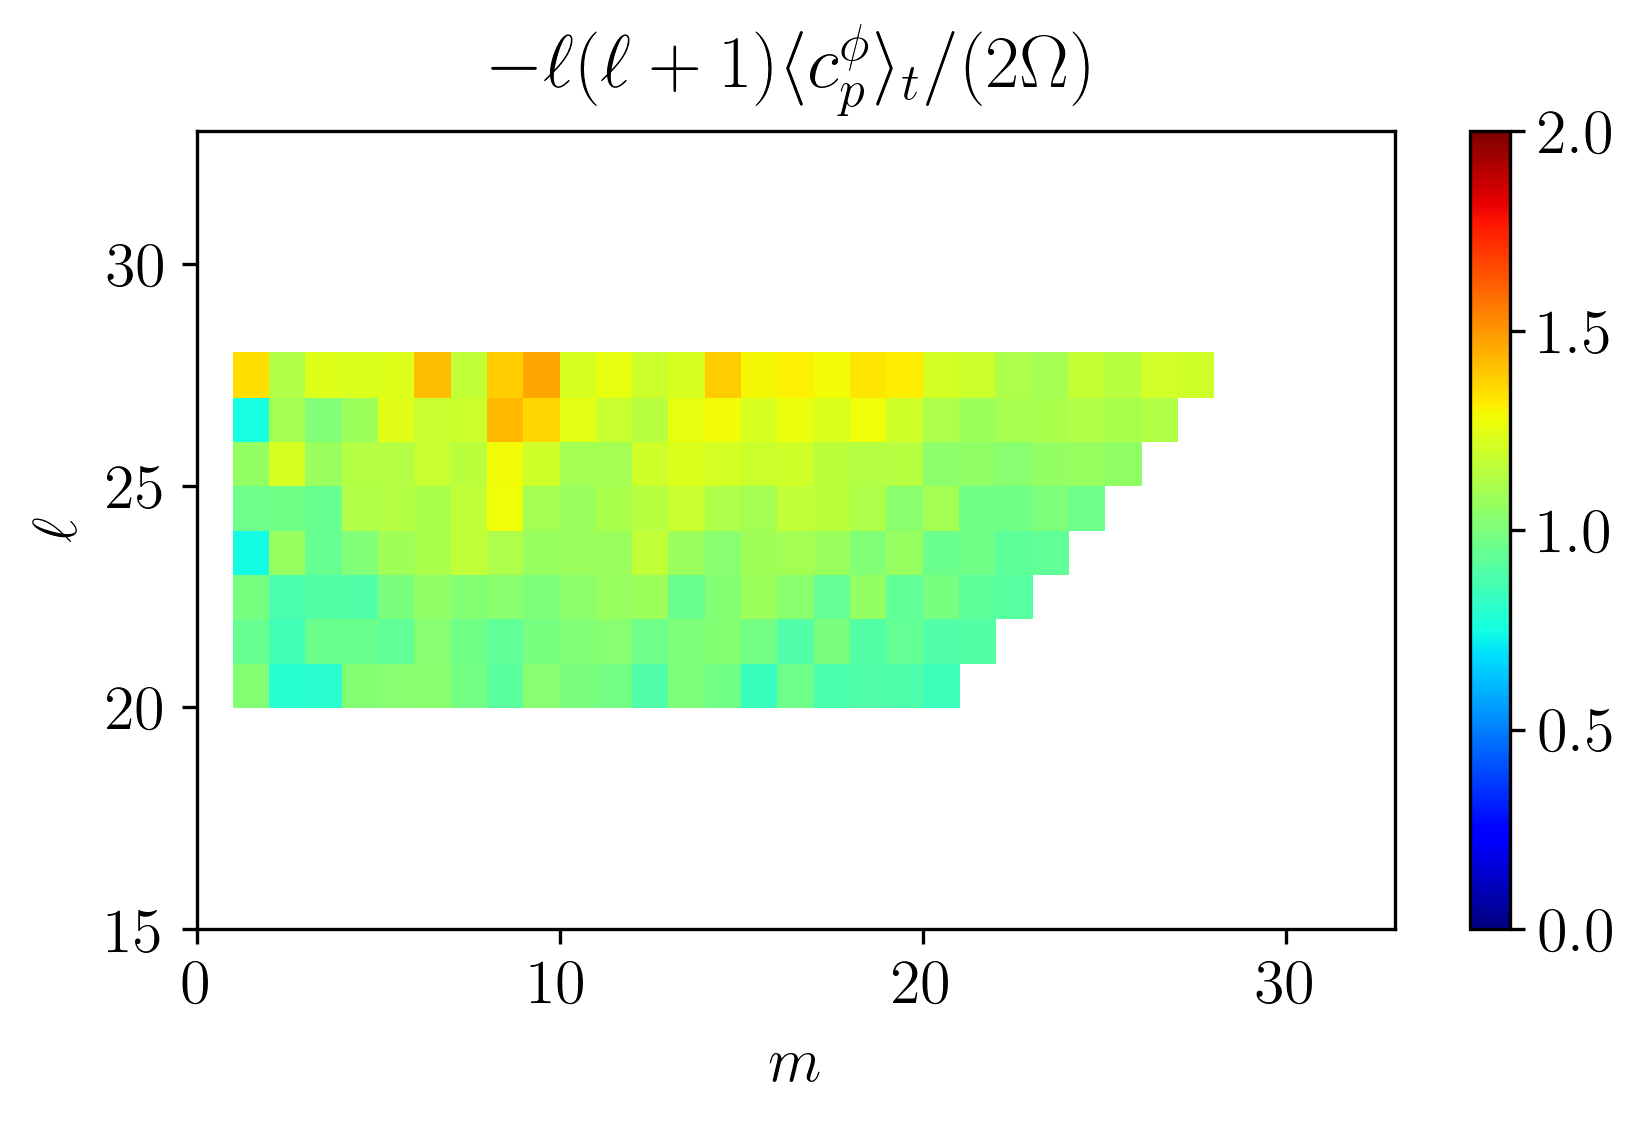

In [22]:
import matplotlib as mpl
fm = mpl.font_manager
fm.get_cachedir()

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

plt.figure(dpi=300)
plt.pcolormesh(mm, ellell, np.real(mean_phase_speed)*ellell*(ellell+1)/(2*Omega), vmin=0, vmax=2, cmap='jet')
plt.xlim([0,l_p+5]); plt.ylim([l_m-5,l_p+5])
plt.colorbar(); plt.title(r'$-\ell (\ell +1) \langle c_p^\phi \rangle_t/(2 \Omega)$', usetex=True)
plt.xlabel(r'$m$', usetex=True); plt.ylabel(r'$\ell$', usetex=True)
plt.tight_layout()
plt.savefig('phase_speed_modes_Omega=%i.png' %(Omega))

//anaconda3/envs/dedalus/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


(0, 40)

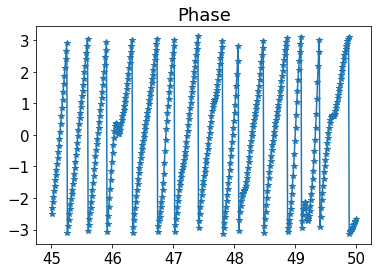

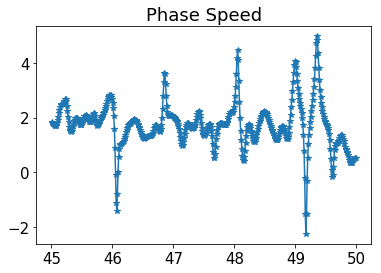

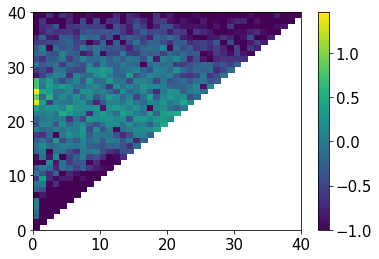

In [20]:
plt.plot(t_arr[4500:], phase[4500:, 10, 25], '*-'); plt.title('Phase')
plt.figure()
plt.plot(t_arr[4500:], phase_speed[4500:, 10, 25], '*-'); plt.title('Phase Speed')

plt.figure()
plt.pcolormesh(mm, ellell, np.log10(Amp), vmin=np.log10(thresh))
plt.colorbar()
plt.xlim([0,40]); plt.ylim([0,40])